In [34]:
import pandas as pd
import json
from sklearn import cross_validation, linear_model, grid_search
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

import pdb

## when working in Py3
# import sys, os; sys.path.append(os.path.abspath("..")) # call Py module from parent dir
# from fetch_data import FetchData 

### base notebook from Marcus & Metis course

# Read in data

In [15]:
with open('../data/peppers_20171013.json') as json_data:
    data = json.load(json_data)
peppers = pd.DataFrame(data["peppers"])
peppers.sample(3)

,heat,link,max_jrp,max_shu,min_jrp,min_shu,name,origin,region,species
98,super hot,http://www.pepperscale.com/caribbean-red-habanero,178,445000,35,300000.0,Caribbean Red Habanero,Mexico,North America,chinense
30,mild,http://www.pepperscale.com/guindilla-pepper,0,2000,-8,1000.0,Guindilla Pepper,Spain,Europe,annuum
85,extra hot,http://www.pepperscale.com/prairie-fire-pepper,32,80000,9,70000.0,Prairie Fire Pepper,Mexico,North America,annuum


# Visualize features

Plot the relationships between min & max JRP & SHU

Number of features: 4


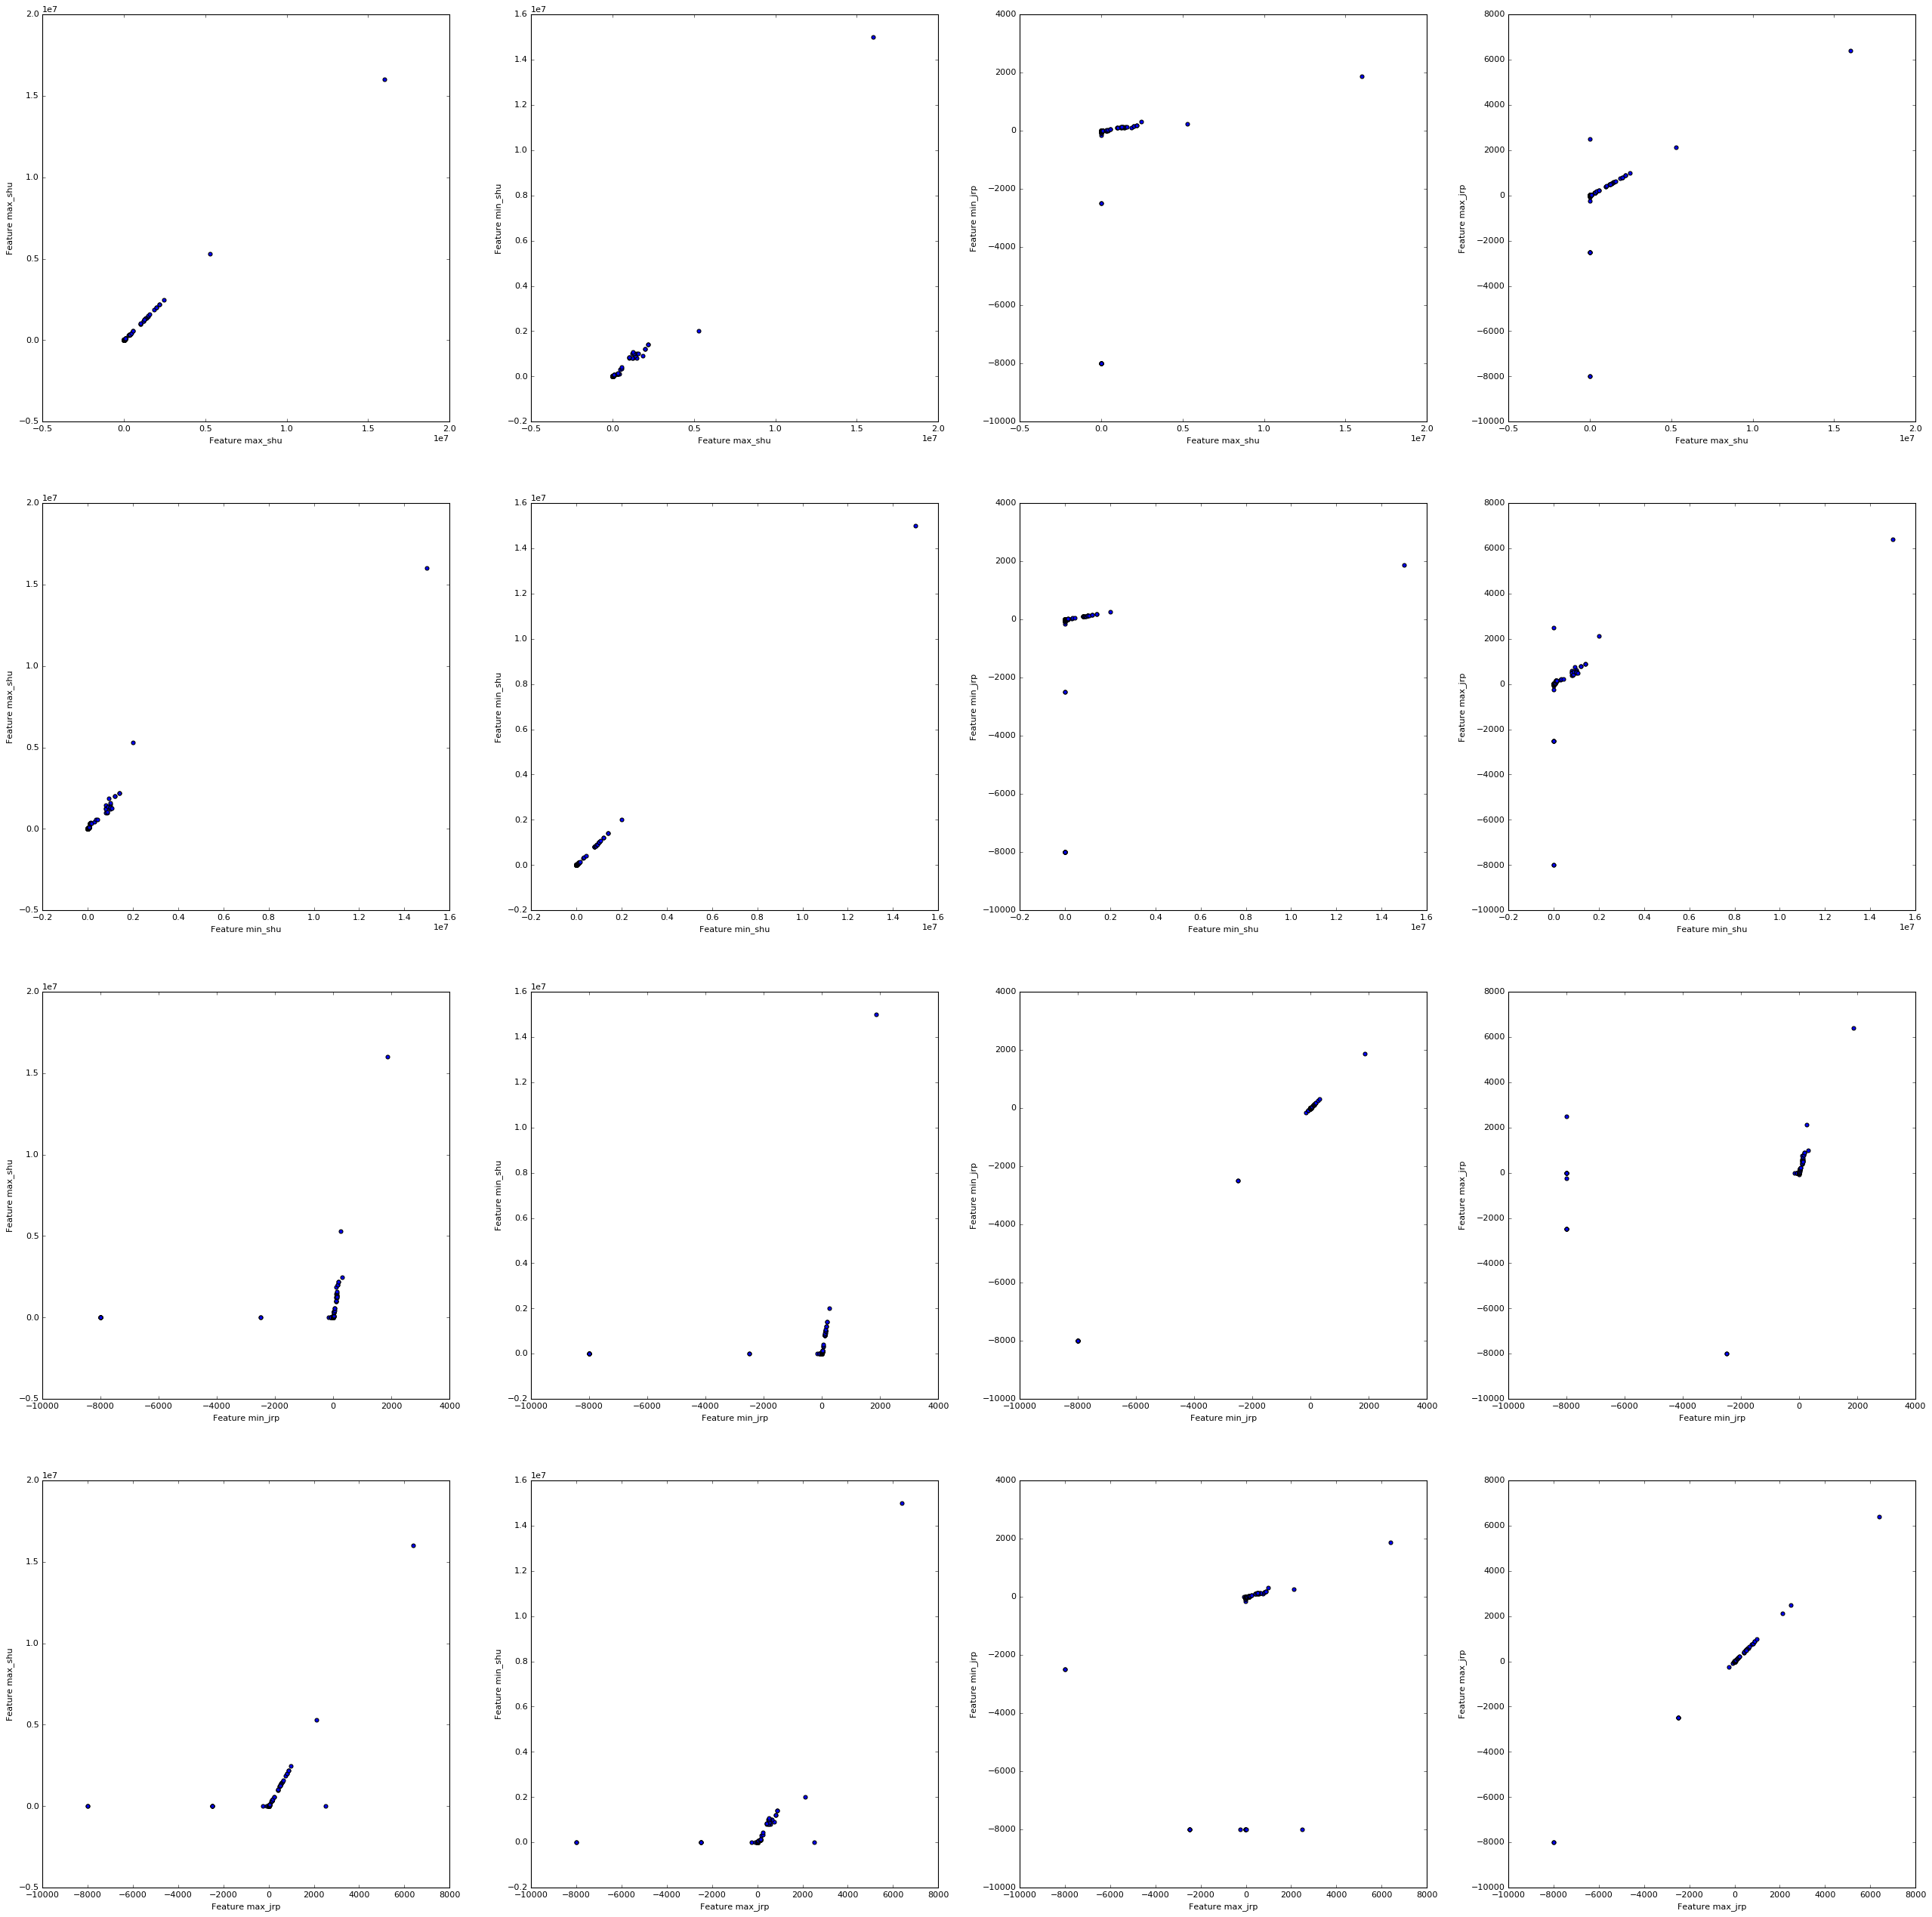

In [53]:
## visualize the relationships between SHU & JRP

features = ["max_shu", "min_shu", "min_jrp", "max_jrp"]

def scatter_matrix(data, features=features):
    feature_count = len(features)
    print "Number of features:", feature_count
    
    fig,ax = plt.subplots(ncols=feature_count,
                          nrows=feature_count,
                          figsize=(10*feature_count, 10*feature_count))

    feature_data = data[features]
    for index_x, feature_x in enumerate(feature_data):
        for index_y, feature_y in enumerate(feature_data):
            ax[index_x][index_y].scatter(data[feature_x], data[feature_y])
            ax[index_x][index_y].set_ylabel('Feature ' + str(feature_y))
            ax[index_x][index_y].set_xlabel('Feature ' + str(feature_x))
            
scatter_matrix(peppers)

## Scatter insights

When comparing min SHU & min JRP and max SHU & max JRP, there are clear outliers around 0 SHU. Otherwise, the relationship is visually well described linearly.

#### Hypothesis
The relationship between JRP and SHU can be represented by a linear regression model when scrubbing the data for outliers at the 0 SHU mark.

# Clean data
Get rid of outliers to scrub the noise from the data and find the line

Resources:
- http://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/

In [99]:
clean_peppers = peppers[(peppers["max_shu"] != 0) & ~(peppers["min_shu"].isnull()) & 
                        (peppers["min_shu"] != 0)][features]
# clean_peppers = peppers[~(peppers["min_jrp"].isin([-8000, -2500, 2500])) & (peppers["max_shu"] != 0) &
#                         ~(peppers["min_shu"].isnull())]
peppers.shape, clean_peppers.shape

((122, 10), (110, 4))

In [103]:
clean_peppers.sort_values(features).drop_duplicates().head(10)
# -8000 is also an outlier, as it's normally associated with 0 and is much lower than other 1000s.

,max_shu,min_shu,min_jrp,max_jrp
13,200,50.0,-160,-13
14,500,100.0,-80,-5
24,700,500.0,-3,-16
26,800,700.0,-10,-3
11,1000,1.0,-8000,-3
12,1000,1.0,-8000,-2
16,1000,100.0,-80,-3
18,1000,100.0,-3,-80
19,1000,500.0,-16,-3
37,1200,1100.0,-7,-2


In [106]:
clean_peppers = clean_peppers[clean_peppers["min_jrp"] != -8000]
peppers.shape, clean_peppers.shape

((122, 10), (108, 4))

# Set up models

Resources: 
- http://scikit-learn.org/stable/modules/linear_model.html
- https://www.datasciencecentral.com/profiles/blogs/10-types-of-regressions-which-one-to-use


In [113]:
reg = linear_model.LinearRegression()
reg.fit(reshape_values(clean_peppers["min_shu"]),
        reshape_values(clean_peppers["min_jrp"]))
reg.coef_

array([[ 0.00012601]])

In [107]:
models = {}
models['ols'] = linear_model.LinearRegression()
models['ridge'] = linear_model.Ridge()
models['lasso'] = linear_model.Lasso(alpha=.002)
models['elasticnet'] = linear_model.ElasticNet()

In [ ]:
def reshape_values(data):
    return data.values.reshape(len(data), 1)

def run_ols(col_type="min"):
    predictors = reshape_values(clean_peppers["{}_shu".format(col_type)])  
    target = reshape_values(clean_peppers["{}_jrp".format(col_type)])
    
    reg = linear_model.LinearRegression()
    

### Min

In [118]:
predictors = reshape_values(clean_peppers["min_jrp"])
target = reshape_values(clean_peppers["min_shu"])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(predictors, target, test_size=0.1)

for name, model in models.items():
    print(name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Model: '+ name)
    print("Score: " + str(model.score(X_test, y_test)))
#     print("MSqE: " + str(mean_squared_error(y_test, y_pred)))
#     print("R^2: " + str(r2_score(y_test, y_pred)))
    sorted_features = sorted(zip(predictors, model.coef_), key=lambda tup: abs(tup[1]), reverse=True)
    for feature in sorted_features:
        print(feature)
        
    print("")

elasticnet
Model: elasticnet
Score: 0.979187002356
(array([-160]), 7832.756802666644)

ols
Model: ols
Score: 0.979187421481
(array([-160]), array([ 7832.85821004]))

ridge
Model: ridge
Score: 0.979187412844
(array([-160]), array([ 7832.85611941]))

lasso
Model: lasso
Score: 0.97918742148
(array([-160]), 7832.8582099919286)

